<a href="https://colab.research.google.com/github/Jaga4512/Bioinformatic_tools/blob/main/rDNA%20pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install biopython freesasa py3Dmol

In [11]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import re
import numpy as np
import os

In [12]:
sequence = "MYRMQLLSCIALSLALVTNSAPTSSSTKKTQLQLEHLLLDLQMVILNGINNYKNPKLTRMLTFKFYMPKKATELKHLQCLEEELKPLEEVLNLAQSKNFHLRPRDLISNINVIVLELKGSETTFMCEYADEKTATIVEFLNRWITFCQSIISTLT"

print("Full Sequence Length:", len(sequence))


Full Sequence Length: 155


In [13]:
def detect_human_signal_peptide(seq):
    """
    Rule-based detection tuned for human secretory proteins.
    """

    hydrophobic = set("AILMVFWY")
    positive = set("KR")

    for length in range(18, 26):
        candidate = seq[:length]

        # N-region positive charge
        if not any(res in positive for res in candidate[:3]):
            continue

        # Hydrophobic core
        hydro_count = sum(res in hydrophobic for res in candidate[:20])
        if hydro_count < 8:
            continue

        # Cleavage motif approximation
        if candidate[-1] in "AST":
            return True, candidate

    return False, None


has_sp, sp_seq = detect_human_signal_peptide(sequence)

print("=== Signal Peptide Analysis ===")

if has_sp:
    print("⚠ Rule-based signal peptide detected:")
    print("Predicted Signal Peptide:", sp_seq)
    print("Predicted cleavage after position:", len(sp_seq))
    print("\nWARNING:")
    print("This is a heuristic prediction and may be inaccurate.")
    print("For accurate native human signal peptide detection use SignalP 6.0 webserver.")
    print("Note: SignalP 6.0 may require license for industrial/commercial usage.")
    mature_sequence = sequence[len(sp_seq):]
else:
    print("No signal peptide detected.")
    mature_sequence = sequence

print("Mature Protein Length:", len(mature_sequence))


=== Signal Peptide Analysis ===
⚠ Rule-based signal peptide detected:
Predicted Signal Peptide: MYRMQLLSCIALSLALVT
Predicted cleavage after position: 18

This is a heuristic prediction and may be inaccurate.
For accurate native human signal peptide detection use SignalP 6.0 webserver.
Note: SignalP 6.0 may require license for industrial/commercial usage.
Mature Protein Length: 137


In [14]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

print("=== Physicochemical Profiling ===")

native_analysis = ProteinAnalysis(sequence)
mature_analysis = ProteinAnalysis(mature_sequence)

print("\n-- Native Protein --")
print("MW:", round(native_analysis.molecular_weight(),2))
print("pI:", round(native_analysis.isoelectric_point(),2))
print("GRAVY:", round(native_analysis.gravy(),3))
print("Instability Index:", round(native_analysis.instability_index(),2))

print("\n-- Mature Protein --")
print("MW:", round(mature_analysis.molecular_weight(),2))
print("pI:", round(mature_analysis.isoelectric_point(),2))
print("GRAVY:", round(mature_analysis.gravy(),3))
print("Instability Index:", round(mature_analysis.instability_index(),2))

=== Physicochemical Profiling ===

-- Native Protein --
MW: 17854.83
pI: 8.34
GRAVY: -0.005
Instability Index: 47.22

-- Mature Protein --
MW: 15846.32
pI: 7.89
GRAVY: -0.196
Instability Index: 51.5


In [15]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = mature_sequence #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
elif template_mode == "none": # Add this else if block
  custom_template_path = None
  use_templates = False
else: # And add this else block to catch any other template_mode
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname test_1cb93
sequence NSAPTSSSTKKTQLQLEHLLLDLQMVILNGINNYKNPKLTRMLTFKFYMPKKATELKHLQCLEEELKPLEEVLNLAQSKNFHLRPRDLISNINVIVLELKGSETTFMCEYADEKTATIVEFLNRWITFCQSIISTLT
length 137


In [16]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

# Ensure colabfold is installed
if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 3.41 ms, sys: 1.58 ms, total: 4.99 ms
Wall time: 18.6 s


In [17]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [18]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2026-02-06 07:19:35,215 WARNING: no GPU detected, will be using CPU
2026-02-06 07:19:44,260 Found 5 citations for tools or databases
2026-02-06 07:19:44,260 Query 1/1: test_1cb93 (length 137)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


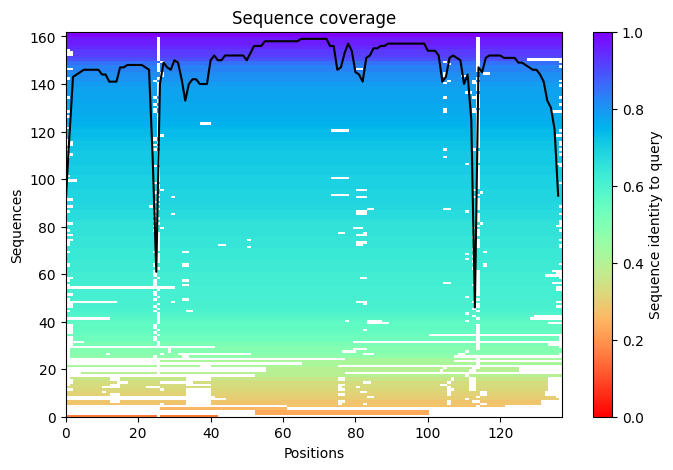

2026-02-06 07:19:46,388 Setting max_seq=162, max_extra_seq=1
2026-02-06 07:23:17,882 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=77.4 pTM=0.731
2026-02-06 07:26:39,606 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=74.1 pTM=0.697 tol=1.14
2026-02-06 07:29:32,952 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=74.9 pTM=0.709 tol=0.607
2026-02-06 07:32:24,165 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=75.6 pTM=0.717 tol=0.287
2026-02-06 07:32:24,167 alphafold2_ptm_model_1_seed_000 took 744.9s (3 recycles)


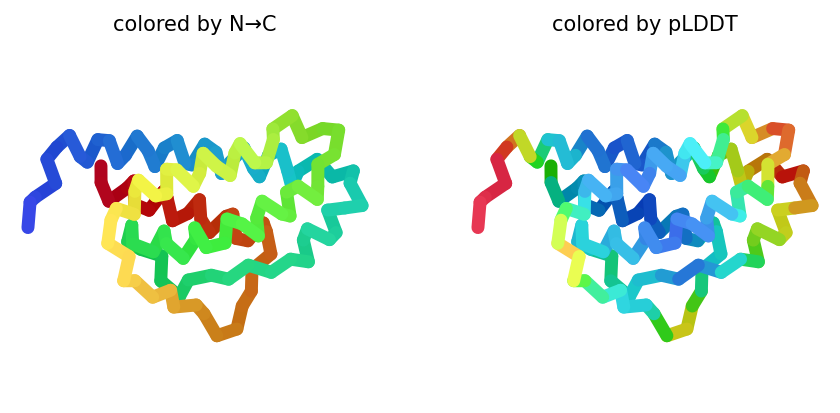

2026-02-06 07:35:16,468 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=72.3 pTM=0.683
2026-02-06 07:38:06,621 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=70.6 pTM=0.665 tol=0.946
2026-02-06 07:40:57,477 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=75.6 pTM=0.723 tol=0.966
2026-02-06 07:43:48,324 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=78.9 pTM=0.753 tol=0.583
2026-02-06 07:43:48,326 alphafold2_ptm_model_2_seed_000 took 684.0s (3 recycles)


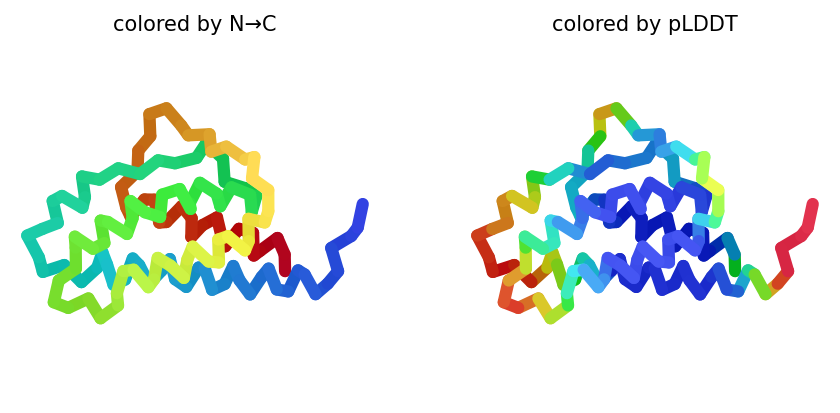

2026-02-06 07:46:38,425 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=79.3 pTM=0.734
2026-02-06 07:49:28,384 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=77.6 pTM=0.718 tol=0.652
2026-02-06 07:52:17,507 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=78.7 pTM=0.714 tol=0.396
2026-02-06 07:55:08,035 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=81.3 pTM=0.76 tol=0.265
2026-02-06 07:55:08,037 alphafold2_ptm_model_3_seed_000 took 679.5s (3 recycles)


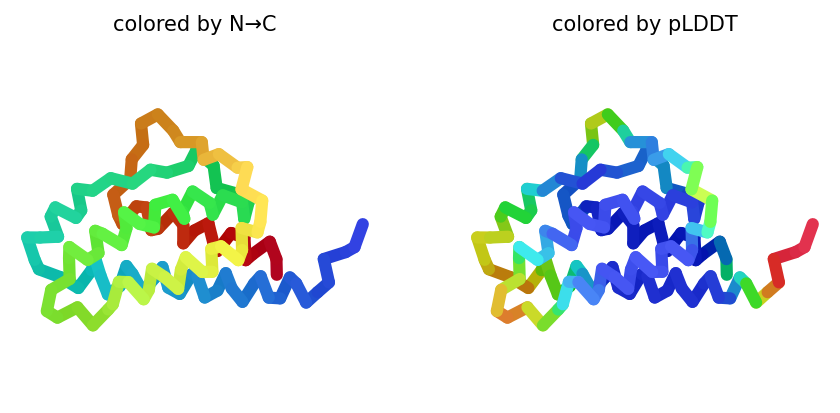

2026-02-06 07:58:01,602 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=77.1 pTM=0.71
2026-02-06 08:00:51,032 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=76.8 pTM=0.711 tol=0.783
2026-02-06 08:03:41,784 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=74.8 pTM=0.689 tol=0.407


In [ ]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [ ]:
import freesasa
from Bio.PDB import PDBParser, NeighborSearch
from Bio.PDB import is_aa # Corrected import for is_aa

# SASA Calculation
sasa_pdb_path = pdb_file[0] # Use the generated PDB file from the previous step

structure = freesasa.Structure(sasa_pdb_path)
result = freesasa.calc(structure)

residue_sasa = {}

for i in range(structure.nAtoms()):
    atom = structure.atomName(i)
    resnum = structure.residueNumber(i)
    chain = structure.chainLabel(i)
    area = result.atomArea(i)

    key = (chain, resnum) # freesaSA residue numbers are strings with leading spaces
    residue_sasa.setdefault(key, 0)
    residue_sasa[key] += area

print("Calculated SASA for", len(residue_sasa), "residues")

# Surface-exposed hydrophobic residues
hydrophobic_residues = ["ALA","VAL","ILE","LEU","MET","PHE","TRP","TYR"]

parser = PDBParser()
structure_bio = parser.get_structure("protein", pdb_file[0]) # Use pdb_file[0] as it's a list

surface_hydrophobic = []

for model in structure_bio:
    for chain in model:
        for residue in chain:
            if is_aa(residue):
                # res_id from Biopython PDB is (hetero_flag, residue_number, insertion_code)
                # residue_sasa uses (chain_id, residue_number as string)
                # Need to convert Biopython res_id[1] (int) to string and add padding if freesasa adds it.
                sasa_key_from_bio = (chain.id, str(residue.get_id()[1]))

                # freesasa outputs residue numbers with leading spaces, e.g., '  10 '
                # We need to account for this formatting if direct string matching fails
                # A safer approach is to iterate through residue_sasa keys and match by number
                matched_sasa_key = None
                for sasa_key in residue_sasa.keys():
                    if sasa_key[0] == chain.id and str(residue.get_id()[1]) == sasa_key[1].strip():
                        matched_sasa_key = sasa_key
                        break

                resname = residue.get_resname()

                if matched_sasa_key:
                    sasa = residue_sasa[matched_sasa_key]

                    # Rough exposure threshold (Å²)
                    if sasa > 30 and resname in hydrophobic_residues:
                        surface_hydrophobic.append(residue)

print("\nSurface-exposed hydrophobic residues:")
print([res.get_id()[1] for res in surface_hydrophobic])

# Potential Aggregation Hotspots
atoms = [atom for atom in structure_bio.get_atoms()]
ns = NeighborSearch(atoms)

clusters = []

for residue in surface_hydrophobic:
    center_atoms = [atom for atom in residue if atom.get_id() == "CA"]
    if not center_atoms:
        continue

    center = center_atoms[0]
    neighbors = ns.search(center.coord, 4.0)  # 4 Å cutoff

    nearby_hydro = []
    for atom in neighbors:
        parent = atom.get_parent()
        # Check if the parent is a residue object and if it's in surface_hydrophobic
        # Also ensure it's not the same residue we're currently considering
        if parent and hasattr(parent, 'get_id') and parent in surface_hydrophobic and parent != residue:
            nearby_hydro.append(parent.get_id()[1])

    if nearby_hydro:
        clusters.append((residue.get_id()[1], nearby_hydro))

print("\n=== Potential Aggregation Hotspots ===")
if clusters:
    for cluster in clusters:
        print(f"Residue {cluster[0]} clusters with {cluster[1]}")
else:
    print("No aggregation hotspots detected based on the current criteria.")

In [ ]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
from google.colab import files
import os
import re

rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
download_pdb = False #@param {type:"boolean"}

# Ensure jobname and msa_mode are defined from previous cells (kOblAo-xetgx and C2_sh2uAonJH).
# If not defined, this block might still fail for other NameErrors.
if 'jobname' not in globals() or 'msa_mode' not in globals():
    print("Error: 'jobname' or 'msa_mode' not found. Please ensure previous cells are executed.")
    # Set dummy values to prevent immediate failure, but functionality will be limited
    jobname = "dummy_job"
    msa_mode = "mmseqs2_uniref_env"

jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename_pattern = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_rank_*.pdb"

tag = None
# Attempt to get tag from 'results' if available
if 'results' in globals() and isinstance(results, dict) and "rank" in results:
    if len(results["rank"]) >= rank_num:
        tag = results["rank"][rank_num - 1][0]
    else:
        print(f"Warning: rank_num ({rank_num}) is out of bounds for 'results' rankings. Falling back to file-based inference.")
else:
    print("Warning: 'results' variable not found or invalid. Attempting to infer PDB filename from job directory.")

# Fallback/alternative if 'results' not available or rank_num is invalid
if tag is None:
    all_pdb_files = glob.glob(pdb_filename_pattern)
    if all_pdb_files:
        def get_rank_from_filename(filepath):
            match = re.search(r"_rank_(\d{3})_", os.path.basename(filepath))
            if match:
                return int(match.group(1))
            return float('inf') # Put files without rank at the end

        all_pdb_files.sort(key=get_rank_from_filename)

        if len(all_pdb_files) >= rank_num:
            selected_pdb_filepath = all_pdb_files[rank_num - 1]
            tag_match = re.search(r"unrelaxed_(rank_\d{3}_.+)\.pdb$", os.path.basename(selected_pdb_filepath))
            if tag_match:
                tag = tag_match.group(1)
                print(f"Inferred tag for rank {rank_num}: {tag}")
            else:
                print(f"Error: Could not extract tag from filename: {os.path.basename(selected_pdb_filepath)}")
        else:
            print(f"Error: Not enough ranked PDB files found to satisfy rank_num={rank_num}. Found {len(all_pdb_files)} files.")
    else:
        print("Error: No unrelaxed PDB files found in the job directory. Cannot proceed without 'results' or PDB files.")

pdb_file = []
if tag:
    final_pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
    pdb_file = glob.glob(final_pdb_filename)
else:
    print("No valid PDB file could be determined. Skipping 3D visualization.")

# Ensure queries and is_complex are defined for show_pdb function
if 'queries' not in globals() or not isinstance(queries, list):
    print("Warning: 'queries' variable not found or invalid. Setting a dummy query for visualization.")
    if 'mature_sequence' in globals():
        queries = [("", mature_sequence)]
    else:
        # Fallback if even mature_sequence is missing
        queries = [("", "UNDEFINED_SEQUENCE")]
    is_complex = False
elif 'is_complex' not in globals() or not isinstance(is_complex, bool):
    print("Warning: 'is_complex' variable not found or invalid. Setting to False for visualization.")
    is_complex = False

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT", aggregation_regions=None, surface_opacity=0.8, highlight_color='yellow', surface_color='lightgrey', highlight_residue_ids=None):
  # Check if pdb_file is empty
  if not pdb_file:
    print("No PDB file available for display.")
    return None # Return None if no PDB file to display

  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  # Re-introduce cartoon coloring logic
  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    # Ensure queries is a valid list before accessing its elements
    if queries and isinstance(queries, list) and queries[0] and isinstance(queries[0], tuple):
      chains = len(queries[0][1]) + 1 if is_complex else 1
    else:
      chains = 1 # Default to 1 chain if queries is not properly defined
    for n,chain,color_val in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color_val}})
  else:
    # Default cartoon color if not lDDT, rainbow, or chain
    view.setStyle({'cartoon': {'color':color}})

  # Add surface representation
  view.addSurface(py3Dmol.VDW, {'opacity':surface_opacity,'color':surface_color})

  # Highlight aggregation-prone regions if provided (old logic)
  if aggregation_regions:
    for pos, seg in aggregation_regions:
      # Convert 1-indexed position to py3Dmol residue selection
      resi_list = list(range(pos, pos + len(seg)))
      resi_selection_str = ','.join(map(str, resi_list))
      # Increased radius and changed color for better visibility
      view.addStyle({'resi': resi_selection_str}, {'sphere': {'colorscheme': highlight_color, 'radius': 1.2}, 'stick': {'colorscheme': highlight_color, 'radius': 0.6}})

  # New logic: Highlight individual residue IDs if provided
  if highlight_residue_ids and len(highlight_residue_ids) > 0:
    resi_selection_str = ','.join(map(str, sorted(list(set(highlight_residue_ids)))))
    view.addStyle({'resi': resi_selection_str}, {'sphere': {'colorscheme': highlight_color, 'radius': 1.2}, 'stick': {'colorscheme': highlight_color, 'radius': 0.6}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

# Detect aggregation-prone regions (always calculate for potential use)
hydrophobic_residues = set("AILMVFWY")
agg_regions = []
# Check if mature_sequence is defined
if 'mature_sequence' in globals():
    for i in range(len(mature_sequence) - 3):
        segment = mature_sequence[i:i+4]
        if all(res in hydrophobic_residues for res in segment):
            agg_regions.append((i+1, segment))
else:
    print("Warning: 'mature_sequence' not found. Cannot detect aggregation-prone regions based on sequence.")


# Extract unique residue IDs from clusters variable for highlighting
cluster_hotspot_residue_ids = set()
if 'clusters' in globals() and isinstance(clusters, list):
    for cluster_tuple in clusters:
        cluster_hotspot_residue_ids.add(cluster_tuple[0]) # Add the central residue ID
        for neighbor_id in cluster_tuple[1]:
            cluster_hotspot_residue_ids.add(neighbor_id) # Add the neighboring residue IDs
    cluster_hotspot_residue_ids = sorted(list(cluster_hotspot_residue_ids))
else:
    print("Warning: 'clusters' variable not found or invalid. Aggregation hotspots will not be highlighted.")

print("=== Predicted pLDDT Scores ===")
# Only call show_pdb if pdb_file is available
if pdb_file:
    plddt_view = show_pdb(rank_num, show_sidechains=False, show_mainchains=False, color="lDDT", aggregation_regions=None, surface_opacity=0.8, surface_color='lightgrey')
    if plddt_view:
        plddt_view.show()
    plot_plddt_legend().show()
else:
    print("Cannot display pLDDT scores: No PDB file available.")


print("\n=== Aggregation Risk (Red Highlighted Regions) ===")
# Pass the extracted cluster hotspot residue IDs to the show_pdb function
if pdb_file:
    agg_view = show_pdb(rank_num, show_sidechains=False, show_mainchains=False, color="blue",
                        highlight_residue_ids=cluster_hotspot_residue_ids, highlight_color='red', surface_opacity=0.8, surface_color='lightgrey')
    if agg_view:
        agg_view.show()
else:
    print("Cannot display Aggregation Risk: No PDB file available.")

# Conditional PDB download functionality (remains unchanged)
if download_pdb:
    if pdb_file:
        selected_pdb_path = pdb_file[0]
        print(f"Downloading: {selected_pdb_path}")
        files.download(selected_pdb_path)
    else:
        print("No PDB file found to download.")

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [ ]:
print("=== Tag Detection ===")

tags_detected = []

if re.search(r"H{6,}", sequence):
    tags_detected.append("6xHis Tag")

if "ENLYFQG" in sequence:
    tags_detected.append("TEV Protease Site")

if "DYKDDDDK" in sequence:
    tags_detected.append("FLAG Tag")

if "GST" in sequence[:30]:
    tags_detected.append("GST Tag")

if tags_detected:
    for tag in tags_detected:
        print("Detected:", tag)
else:
    print("No common affinity tags detected.")


In [ ]:
print("=== Purification Recommendation ===")

pI = mature_analysis.isoelectric_point()

if "6xHis Tag" in tags_detected:
    print("Primary: Ni-NTA Affinity Chromatography")
    print("Binding Buffer: 20 mM Tris-HCl, 300 mM NaCl, 10–20 mM Imidazole, pH 7.5–8.0")
    print("Elution: 250 mM Imidazole")

    if "TEV Protease Site" in tags_detected:
        print("\nAfter TEV cleavage:")
        print("- Reapply to Ni-NTA to remove His-tag + His-TEV protease")
        print("- Final polishing: Size Exclusion Chromatography")
        print("SEC Buffer: 20 mM HEPES, 150 mM NaCl, pH 7.4")

elif "GST Tag" in tags_detected:
    print("Primary: Glutathione Affinity Chromatography")
    print("Buffer: PBS pH 7.4")
    print("Elution: Reduced glutathione")

else:
    if pI < 7:
        print("Recommend: Anion Exchange Chromatography (Q column)")
        print("Buffer: 20 mM Tris-HCl pH 8.0")
    else:
        print("Recommend: Cation Exchange Chromatography (SP column)")
        print("Buffer: 20 mM Sodium Acetate pH 5.5")

    print("Polishing: Size Exclusion Chromatography")
    print("SEC Buffer: 20 mM HEPES, 150 mM NaCl, pH 7.4")
